In [1]:
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
crpc = pd.read_csv("../data/raw/crpc_sections.csv", encoding="latin-1")
ipc = pd.read_csv("../data/raw/ipc_sections.csv", encoding="latin-1")
final_ic = pd.read_csv("../data/raw/Final_IC.csv", encoding="latin-1")


In [15]:
print("Final_IC columns:\n", list(final_ic.columns))
print("\nIPC columns:\n", list(ipc.columns))
print("\nCrPC columns:\n", list(crpc.columns))


Final_IC columns:
 ['article_id', 'article_desc']

IPC columns:
 ['Description', 'Offense', 'Punishment', 'Section']

CrPC columns:
 ['Chapter', 'Chapter_name', 'Chapter_subtype', 'Section', 'Section _name', 'Description']


In [20]:
final_ic.columns = final_ic.columns.str.strip()
ipc.columns = ipc.columns.str.strip()
crpc.columns = crpc.columns.str.strip()


In [17]:
print(final_ic.columns)
print(ipc.columns)
print(crpc.columns)


Index(['article_id', 'article_desc'], dtype='object')
Index(['Description', 'Offense', 'Punishment', 'Section'], dtype='object')
Index(['Chapter', 'Chapter_name', 'Chapter_subtype', 'Section',
       'Section _name', 'Description'],
      dtype='object')


In [18]:
def find_text_column(df):
    for col in df.columns:
        if "description" in col.lower():
            return col
        if "name" in col.lower():
            return col
    raise ValueError("No suitable text column found")


In [21]:
# Extract correct text columns explicitly

final_ic_text = final_ic["article_desc"]
ipc_text = ipc["Description"]
crpc_text = crpc["Description"]


In [22]:
all_text = pd.concat(
    [final_ic_text, ipc_text, crpc_text],
    axis=0
).dropna().reset_index(drop=True)

all_text.head()


0    Name and territory of the Union\n(1) India, th...
1    Admission or establishment of new States: Parl...
2    Sikkim to be associated with the Union Rep by ...
3    Formation of new States and alteration of area...
4    Laws made under Articles 2 and 3 to provide fo...
dtype: object

In [23]:
print("Total rows:", len(all_text))
print("Sample text:\n", all_text.iloc[0])


Total rows: 1431
Sample text:
 Name and territory of the Union
(1) India, that is Bharat, shall be a Union of States
(2) The States and the territories thereof shall be as specified in the First Schedule
(3) The territory of India shall comprise
The territories of the States; the Union territories specified in the First Schedule; and such other territories as may be acquired


In [24]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.isalpha()]        # remove numbers/symbols
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens


In [25]:
tokens_list = all_text.apply(preprocess_text)
tokens_list.head()


0    [name, territory, union, india, bharat, shall,...
1    [admission, establishment, new, state, parliam...
2    [sikkim, associated, union, rep, constitution,...
3    [formation, new, state, alteration, area, boun...
4    [law, made, article, provide, amendment, first...
dtype: object

In [30]:
sentences = tokens_list.tolist()

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)


In [31]:
w2v_model.wv["offence"]


array([-4.0274972e-01,  4.3855470e-01, -3.1241742e-01, -1.6462876e-01,
        2.0016602e-01, -6.7822307e-01,  1.5749875e-01,  9.0491062e-01,
       -1.8700004e-02, -2.1126767e-01,  2.1476158e-01, -6.2415105e-01,
        2.0894177e-01,  2.1976554e-01,  1.5375592e-01, -7.6362431e-02,
        3.7123942e-01,  4.0540958e-04,  9.0046532e-02, -9.6038008e-01,
       -8.0072591e-03,  8.2464673e-02,  6.7436612e-01, -2.9053178e-01,
        4.2485711e-01, -9.3497403e-02, -2.8994325e-01, -2.6914570e-01,
       -3.8379516e-02, -7.8209713e-02, -1.7876731e-01,  5.8547653e-02,
        5.2917129e-01, -3.5914239e-01, -2.9687479e-01,  9.8849171e-01,
       -2.1586044e-01, -4.1472104e-01, -5.4688507e-01, -7.6897186e-01,
       -2.2324167e-01, -4.2852205e-01,  1.8240206e-02,  9.0419479e-02,
        5.6901789e-01, -5.0739646e-01, -4.6908331e-01,  2.5573624e-02,
        3.4662494e-01,  6.2315547e-01,  3.9971799e-02, -3.6782452e-01,
       -5.7901818e-01,  8.1050068e-01, -4.8494908e-01,  1.7555232e-01,
      

In [32]:
print("Vocabulary size:", len(w2v_model.wv))
print("Embedding dimension:", w2v_model.vector_size)


Vocabulary size: 3353
Embedding dimension: 100


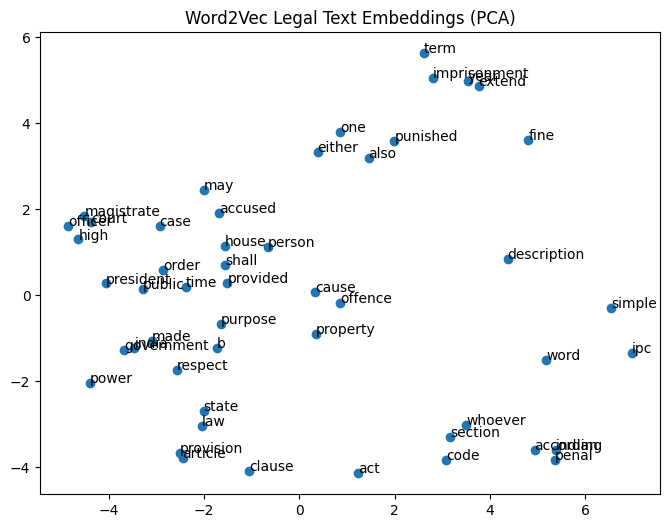

In [33]:
words = list(w2v_model.wv.index_to_key)[:50]
vectors = np.array([w2v_model.wv[word] for word in words])

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

plt.figure(figsize=(8,6))
plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1])

for i, word in enumerate(words):
    plt.annotate(word, (reduced_vectors[i,0], reduced_vectors[i,1]))

plt.title("Word2Vec Legal Text Embeddings (PCA)")
plt.show()


In [34]:
print(final_ic.shape)
print(ipc.shape)
print(crpc.shape)


(454, 2)
(444, 4)
(534, 6)


In [35]:
print(all_text.iloc[0])
print(all_text.iloc[10])
sample_text = "The court found the defendant guilty of the offence under the new act of 2020."

Name and territory of the Union
(1) India, that is Bharat, shall be a Union of States
(2) The States and the territories thereof shall be as specified in the First Schedule
(3) The territory of India shall comprise
The territories of the States; the Union territories specified in the First Schedule; and such other territories as may be acquired
Continuance of the rights of citizenship Every person who is or is deemed to be a citizen of India under any of the foregoing provisions of this Part shall, subject to the provisions of any law that may be made by Parliament, continue to be such citizen


In [36]:
sample = all_text.iloc[0]
print("RAW:\n", sample)

print("\nTOKENS:\n", preprocess_text(sample))


RAW:
 Name and territory of the Union
(1) India, that is Bharat, shall be a Union of States
(2) The States and the territories thereof shall be as specified in the First Schedule
(3) The territory of India shall comprise
The territories of the States; the Union territories specified in the First Schedule; and such other territories as may be acquired

TOKENS:
 ['name', 'territory', 'union', 'india', 'bharat', 'shall', 'union', 'state', 'state', 'territory', 'thereof', 'shall', 'specified', 'first', 'schedule', 'territory', 'india', 'shall', 'comprise', 'territory', 'state', 'union', 'territory', 'specified', 'first', 'schedule', 'territory', 'may', 'acquired']


In [41]:
len(w2v_model.wv)


3353

In [42]:
# LEGAL-AWARE PREPROCESSING (REPLACE OLD CELL)

stop_words = set(stopwords.words("english"))

# IMPORTANT: keep legal words
legal_keep_words = {
    "section", "act", "court", "offence", "offense",
    "punishment", "punish", "whoever", "shall"
}

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    tokens = word_tokenize(text)

    # keep alphabetic words only
    tokens = [w for w in tokens if w.isalpha()]

    # remove stopwords EXCEPT legal words
    tokens = [
        w for w in tokens
        if (w not in stop_words) or (w in legal_keep_words)
    ]

    # lemmatization
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return tokens


In [46]:
tokens_list = all_text.apply(preprocess_text)
clean_sentences = tokens_list.apply(lambda x: " ".join(x))
X_tfidf = tfidf.fit_transform(clean_sentences)
print(X_tfidf.shape)
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
)





(1431, 5000)


In [48]:
print(clean_sentences.iloc[0])
X_tfidf = tfidf.fit_transform(clean_sentences)
print(X_tfidf.shape)
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
)

tfidf_df.iloc[0].sort_values(ascending=False).head(10)


name territory union india bharat shall union state state territory thereof shall specified first schedule territory india shall comprise territory state union territory specified first schedule territory may acquired
(1431, 5000)


territory            0.581868
specified first      0.336636
first schedule       0.289381
union                0.262833
schedule             0.223111
first                0.191407
specified            0.175591
territory state      0.172423
territory thereof    0.168318
acquired             0.156282
Name: 0, dtype: float64

In [49]:
print("Empty sentences:", (clean_sentences == "").sum())


Empty sentences: 0
